### Import Library 

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
#import cv2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

#using tensor board
import datetime


### Data Path for Data Test and Data Train and visualization

Text(0.5, 0.98, 'The first image of every class')

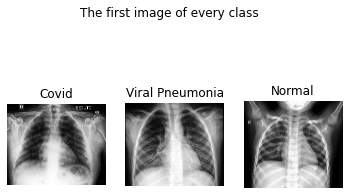

In [2]:
train_data_path = "train"
test_data_path = "test"
figure,x = plt.subplots(1,3)
x[0].imshow(plt.imread(os.path.join(train_data_path, "Covid/01.jpeg")))
x[0].set_title("Covid")
x[0].axis('off')
x[1].imshow(plt.imread(os.path.join(train_data_path, "Viral Pneumonia/01.jpeg")))
x[1].set_title("Viral Pneumonia")
x[1].axis('off')
x[2].imshow(plt.imread(os.path.join(train_data_path, "Normal/01.jpeg")))
x[2].set_title("Normal")
x[2].axis('off')
figure.suptitle("The first image of every class")

### Image Preparation for Model

In [6]:
##image augmentaion
train_images = ImageDataGenerator(rescale=1./255,rotation_range=20,horizontal_flip=True,shear_range = 0.2,fill_mode = 'nearest')
train_dataset = train_images.flow_from_directory(train_data_path,target_size=(150,150),batch_size = 251, class_mode = 'categorical',shuffle=True)

Found 251 images belonging to 3 classes.


In [9]:
train_dataset.class_indices
X, y = train_dataset.next()
print(len(X))

251


In [11]:
print(X[0],y[0])

[[[0.38196024 0.38196024 0.38196024]
  [0.37357163 0.37357163 0.37357163]
  [0.4104673  0.4104673  0.4104673 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.38888553 0.38888553 0.38888553]
  [0.366095   0.366095   0.366095  ]
  [0.4000137  0.4000137  0.4000137 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.3989483  0.3989483  0.3989483 ]
  [0.37280354 0.37280354 0.37280354]
  [0.3888328  0.3888328  0.3888328 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.5779795  0.5779795  0.5779795 ]
  [0.5655465  0.5655465  0.5655465 ]
  [0.5396356  0.5396356  0.5396356 ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [12]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["acc"]
        if accuracy >= self.threshold:
            self.model.stop_training = True
end=MyThresholdCallback(threshold=.92)


### Test dataset

In [13]:
test = ImageDataGenerator(rescale=1/255)                                       
test_dataset = test.flow_from_directory(test_data_path,target_size=(150, 150),batch_size=32,shuffle=False)

test_steps_per_epoch = np.math.ceil(test_dataset.samples / test_dataset.batch_size)


Found 66 images belonging to 3 classes.


### Modeling, Toning and Evaluation<br>
I started with a small general model and then added more complexity until I started having an overfitting problem, then I moved on to a convolutional neural network. I have built 4 models and the last one was the best.

In [47]:
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
tf.random.set_seed(42)

model1 = Sequential()
#the dimension of our digit images is 28×28.Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called Flatten, to change tensor shape from 28×28 to 784
model1.add(Flatten(input_shape=(150,150,3)))
#We want th output of the network to return the probability of the input digit being equal to  . Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called Softmax.
model1.add(Dense(3,activation="softmax"))
           
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model1.summary()
#that model's val_accuracy is already 92.2% although it's very simple one

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 67500)             0         
                                                                 
 dense_6 (Dense)             (None, 3)                 202503    
                                                                 
Total params: 202,503
Trainable params: 202,503
Non-trainable params: 0
_________________________________________________________________


In [48]:
history1 = model1.fit(train_dataset, 
                    epochs=15,
                    callbacks=[end])

Epoch 1/15
8/8 [==============================] - 5s 586ms/step - loss: 18.5588 - acc: 0.4024
Epoch 2/15
8/8 [==============================] - 5s 596ms/step - loss: 6.5112 - acc: 0.5578
Epoch 3/15
8/8 [==============================] - 5s 666ms/step - loss: 2.4651 - acc: 0.7689
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 1.5468 - acc: 0.8446
Epoch 5/15
8/8 [==============================] - 7s 845ms/step - loss: 1.7015 - acc: 0.8088
Epoch 6/15
8/8 [==============================] - 8s 1s/step - loss: 1.4287 - acc: 0.8526
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 1.1465 - acc: 0.8765
Epoch 8/15
8/8 [==============================] - 8s 1s/step - loss: 0.9328 - acc: 0.8924
Epoch 9/15
8/8 [==============================] - 8s 1s/step - loss: 0.8055 - acc: 0.9163
Epoch 10/15
8/8 [==============================] - 8s 1s/step - loss: 0.6665 - acc: 0.8845
Epoch 11/15
8/8 [==============================] - 9s 1s/step - loss: 0.7901 - acc: 0.

In [50]:
_, accuracy = model1.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

Found 66 images belonging to 3 classes.
3/3 [==============================] - 1s 144ms/step - loss: 1.4667 - acc: 0.7576
Accuracy: 75.76


In [56]:
tf.random.set_seed(42)
model3 = Sequential()
model3.add(Flatten(input_shape=(150,150,3)))

model3.add(Dense(15,activation="relu"))     
model3.add(Dense(25,activation="relu"))     

#We want th output of the network to return the probability of the input digit being equal to  . Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called Softmax.
model3.add(Dense(3,activation="softmax"))
           
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model3.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 67500)             0         
                                                                 
 dense_13 (Dense)            (None, 15)                1012515   
                                                                 
 dense_14 (Dense)            (None, 25)                400       
                                                                 
 dense_15 (Dense)            (None, 3)                 78        
                                                                 
Total params: 1,012,993
Trainable params: 1,012,993
Non-trainable params: 0
_________________________________________________________________


In [57]:
history3 = model3.fit(train_dataset, 
                    epochs=100,callbacks=[end],
                    batch_size=32)

Epoch 1/100
8/8 [==============================] - 5s 628ms/step - loss: 5.6113 - acc: 0.4104
Epoch 2/100
8/8 [==============================] - 6s 688ms/step - loss: 1.3604 - acc: 0.6096
Epoch 3/100
8/8 [==============================] - 5s 688ms/step - loss: 0.6659 - acc: 0.8287
Epoch 4/100
8/8 [==============================] - 5s 668ms/step - loss: 0.6104 - acc: 0.7729
Epoch 5/100
8/8 [==============================] - 5s 590ms/step - loss: 0.5528 - acc: 0.8088
Epoch 6/100
8/8 [==============================] - 6s 708ms/step - loss: 0.4253 - acc: 0.8765
Epoch 7/100
8/8 [==============================] - 6s 712ms/step - loss: 0.3658 - acc: 0.8884
Epoch 8/100
8/8 [==============================] - 5s 652ms/step - loss: 0.3360 - acc: 0.8884
Epoch 9/100
8/8 [==============================] - 5s 644ms/step - loss: 0.2585 - acc: 0.9004
Epoch 10/100
8/8 [==============================] - 5s 643ms/step - loss: 0.2980 - acc: 0.8884
Epoch 11/100
8/8 [==============================] - 5s 644m

KeyboardInterrupt: 

In [58]:
_, accuracy = model3.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

Found 66 images belonging to 3 classes.
3/3 [==============================] - 1s 142ms/step - loss: 0.7955 - acc: 0.7576
Accuracy: 75.76


In [41]:
tf.random.set_seed(42)
model6 = Sequential()
model6.add(Flatten(input_shape=(150,150,3)))

model6.add(Dense(25,activation="relu"))     
model6.add(Dense(15,activation="relu"))     
model6.add(Dense(25,activation="relu"))     

#We want th output of the network to return the probability of the input digit being equal to  . Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called Softmax.
model6.add(Dense(3,activation="softmax"))
           
model6.compile(keras.optimizers.Adam(
   learning_rate = 0.00005, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
),loss='categorical_crossentropy',metrics=['acc'])
model6.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 67500)             0         
                                                                 
 dense_28 (Dense)            (None, 25)                1687525   
                                                                 
 dense_29 (Dense)            (None, 15)                390       
                                                                 
 dense_30 (Dense)            (None, 25)                400       
                                                                 
 dense_31 (Dense)            (None, 3)                 78        
                                                                 
Total params: 1,688,393
Trainable params: 1,688,393
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Logging the training process data to use later in tensorboard
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [43]:
end=MyThresholdCallback(threshold=.92)
history6 = model6.fit(train_dataset, 
                    epochs=100,callbacks=[tensorboard_callback,end],
                    batch_size=32)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.2314 - acc: 0.2789
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.4086 - acc: 0.2789
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.0217 - acc: 0.5498
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 0.9854 - acc: 0.6135
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 0.9644 - acc: 0.5578
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 0.9468 - acc: 0.5657
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 0.9050 - acc: 0.6494
Epoch 8/100
1/1 [==============================] - 5s 5s/step - loss: 0.8742 - acc: 0.6813
Epoch 9/100
1/1 [==============================] - 5s 5s/step - loss: 0.8532 - acc: 0.6494
Epoch 10/100
1/1 [==============================] - 5s 5s/step - loss: 0.8305 - acc: 0.6454
Epoch 11/100
1/1 [==============================] - 5s 5s/step - loss: 0.7991 - acc: 0.67

1/1 [==============================] - 6s 6s/step - loss: 0.2868 - acc: 0.9084
Epoch 91/100
1/1 [==============================] - 6s 6s/step - loss: 0.2949 - acc: 0.9124
Epoch 92/100
1/1 [==============================] - 6s 6s/step - loss: 0.2903 - acc: 0.9163
Epoch 93/100
1/1 [==============================] - 5s 5s/step - loss: 0.3037 - acc: 0.8884
Epoch 94/100
1/1 [==============================] - 5s 5s/step - loss: 0.3005 - acc: 0.9084
Epoch 95/100
1/1 [==============================] - 5s 5s/step - loss: 0.3046 - acc: 0.8964
Epoch 96/100
1/1 [==============================] - 5s 5s/step - loss: 0.2954 - acc: 0.8924
Epoch 97/100
1/1 [==============================] - 5s 5s/step - loss: 0.2814 - acc: 0.9044
Epoch 98/100
1/1 [==============================] - 5s 5s/step - loss: 0.2805 - acc: 0.8924
Epoch 99/100
1/1 [==============================] - 5s 5s/step - loss: 0.2935 - acc: 0.9004
Epoch 100/100
1/1 [==============================] - 5s 5s/step - loss: 0.2736 - acc: 0.9004


In [44]:
_, accuracy = model6.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

3/3 [==============================] - 1s 151ms/step - loss: 0.6058 - acc: 0.7879
Accuracy: 78.79


In [45]:
accuracy = history6.history['acc']
loss = history6.history['loss']

Text(0, 0.5, 'accuracy')

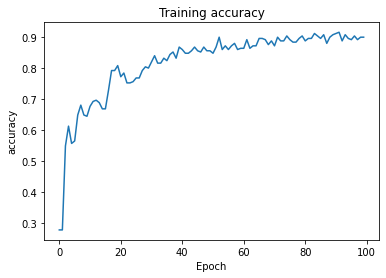

In [46]:
plt.title('Training accuracy')
sns.lineplot(data=accuracy)
plt.xlabel('Epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'Loss')

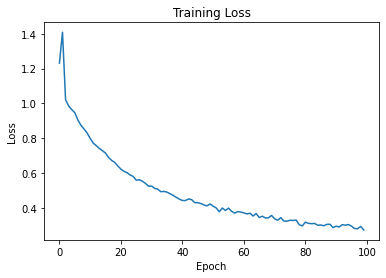

In [47]:
plt.title('Training Loss')
sns.lineplot(data=loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [48]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

In [96]:
test = ImageDataGenerator(rescale=1/255)                                       
test_dataset = test.flow_from_directory(test_data_path,target_size=(150, 150),batch_size=32,shuffle=False)

test_steps_per_epoch = np.math.ceil(test_dataset.samples / test_dataset.batch_size)

predictions = model6.predict(test_dataset, steps=test_steps_per_epoch)


predicted_classes = np.argmax(predictions, axis=1)

Found 66 images belonging to 3 classes.
3/3 [==============================] - 1s 133ms/step


In [97]:
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys()) 

In [98]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.89      0.92      0.91        26
         Normal       0.79      0.95      0.86        20
Viral Pneumonia       0.93      0.70      0.80        20

       accuracy                           0.86        66
      macro avg       0.87      0.86      0.86        66
   weighted avg       0.87      0.86      0.86        66



In [115]:
tf.random.set_seed(42)
model99 = Sequential()
model99.add(Flatten(input_shape=(150,150,3)))


model99.add(Dense(5,activation="relu")) 
model99.add(Dense(10,activation="relu"))
model99.add(Dense(15,activation="relu"))     
model99.add(Dense(30,activation="relu"))     


#We want th output of the network to return the probability of the input digit being equal to  . Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called Softmax.
model99.add(Dense(3,activation="softmax"))
           
model99.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model99.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 67500)             0         
                                                                 
 dense_52 (Dense)            (None, 5)                 337505    
                                                                 
 dense_53 (Dense)            (None, 10)                60        
                                                                 
 dense_54 (Dense)            (None, 15)                165       
                                                                 
 dense_55 (Dense)            (None, 30)                480       
                                                                 
 dense_56 (Dense)            (None, 3)                 93        
                                                                 
Total params: 338,303
Trainable params: 338,303
Non-t

In [116]:
end=MyThresholdCallback(threshold=.9)
history4 = model99.fit(train_dataset, 
                    epochs=100,callbacks=[end],
                    batch_size=32)

Epoch 1/100
8/8 [==============================] - 5s 546ms/step - loss: 1.5078 - acc: 0.3944
Epoch 2/100
8/8 [==============================] - 4s 525ms/step - loss: 0.9347 - acc: 0.5777
Epoch 3/100
8/8 [==============================] - 4s 531ms/step - loss: 0.8284 - acc: 0.5896
Epoch 4/100
8/8 [==============================] - 4s 529ms/step - loss: 0.7328 - acc: 0.6853
Epoch 5/100
8/8 [==============================] - 4s 565ms/step - loss: 0.7125 - acc: 0.6813
Epoch 6/100
8/8 [==============================] - 4s 546ms/step - loss: 0.7931 - acc: 0.5896
Epoch 7/100
8/8 [==============================] - 5s 607ms/step - loss: 0.7753 - acc: 0.6295
Epoch 8/100
8/8 [==============================] - 5s 592ms/step - loss: 0.6718 - acc: 0.6693
Epoch 9/100
8/8 [==============================] - 5s 607ms/step - loss: 0.7333 - acc: 0.6295
Epoch 10/100
8/8 [==============================] - 5s 585ms/step - loss: 0.7047 - acc: 0.6574
Epoch 11/100
8/8 [==============================] - 5s 587m

In [112]:
_, accuracy = model9.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

3/3 [==============================] - 1s 129ms/step - loss: 0.5990 - acc: 0.8182
Accuracy: 81.82


### Using CNN

The Convolutional Neural Network (CNN or ConvNet) is a subtype of Neural Networks that is mainly used for applications in image and speech recognition. Its built-in convolutional layer reduces the high dimensionality of images without losing its information. That is why CNNs are especially suited for this use case.


In [100]:
final_modell = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
final_modell.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
final_modell.add(MaxPool2D(pool_size=(4,4), strides=(2,2)))
final_modell.add(Conv2D(64, kernel_size=5, activation='relu'))
final_modell.add(MaxPool2D(pool_size=(4,4), strides=(2,2)))
final_modell.add(Flatten())
final_modell.add(Dense(128,activation='relu'))
final_modell.add(Dense(3,activation='softmax'))
final_modell.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
final_modell.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 71, 71, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_16 (Flatten)        (None, 65536)             0         
                                                                 
 dense_38 (Dense)            (None, 128)             

In [102]:
finall_history = final_modell.fit(train_dataset, 
                    epochs=20,
                    batch_size=32)

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 4.6261 - acc: 0.3705
Epoch 2/20
8/8 [==============================] - 20s 2s/step - loss: 0.9819 - acc: 0.5418
Epoch 3/20
8/8 [==============================] - 20s 2s/step - loss: 0.5808 - acc: 0.7928
Epoch 4/20
8/8 [==============================] - 23s 3s/step - loss: 0.4627 - acc: 0.8127
Epoch 5/20
8/8 [==============================] - 23s 3s/step - loss: 0.4006 - acc: 0.8446
Epoch 6/20
8/8 [==============================] - 20s 3s/step - loss: 0.2800 - acc: 0.8964
Epoch 7/20
8/8 [==============================] - 19s 2s/step - loss: 0.2727 - acc: 0.9004
Epoch 8/20
8/8 [==============================] - 21s 3s/step - loss: 0.3085 - acc: 0.8526
Epoch 9/20
8/8 [==============================] - 20s 2s/step - loss: 0.2237 - acc: 0.9243
Epoch 10/20
8/8 [==============================] - 21s 3s/step - loss: 0.2387 - acc: 0.9124
Epoch 11/20
8/8 [==============================] - 22s 3s/step - loss: 0.2237 - acc: 0.90

### Doing Classification on Test Dataset using Model

In [104]:
accuracy = finall_history.history['acc']
loss = finall_history.history['loss']

Text(0, 0.5, 'accuracy')

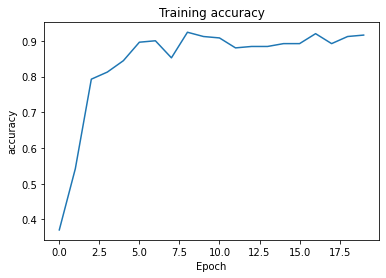

In [105]:
plt.title('Training accuracy')
sns.lineplot(data=accuracy)
plt.xlabel('Epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'Loss')

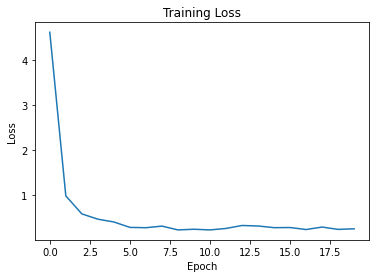

In [106]:
plt.title('Training Loss')
sns.lineplot(data=loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [107]:
test = ImageDataGenerator(rescale=1/255)                                       
test_dataset = test.flow_from_directory(test_data_path,target_size=(150, 150),batch_size=32,shuffle=False)

test_steps_per_epoch = np.math.ceil(test_dataset.samples / test_dataset.batch_size)

predictions = final_modell.predict(test_dataset, steps=test_steps_per_epoch)


predicted_classes = np.argmax(predictions, axis=1)

Found 66 images belonging to 3 classes.
3/3 [==============================] - 1s 264ms/step


In [108]:
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys()) 

In [109]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       1.00      0.69      0.82        26
         Normal       0.59      0.95      0.73        20
Viral Pneumonia       0.88      0.70      0.78        20

       accuracy                           0.77        66
      macro avg       0.82      0.78      0.78        66
   weighted avg       0.84      0.77      0.78        66

